<h1 align="center">DL Assignment: Ionosphere Data Problem (Binary Classification)</h1>

In [4]:
import numpy as np
import pandas as pd

from keras import models
from keras import layers
from keras import regularizers

import matplotlib.pyplot as plt

# Loading Data and Preprocessing

In [5]:
ionosphere_df = pd.read_csv("./ionosphere_data.csv")
ionosphere_df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,label
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


## Checking for Missing Values

There are no missing values in the data.

In [6]:
ionosphere_df.isna().any().any()

False

## Removing Duplicates

There is only 1 duplicate row

In [7]:
ionosphere_df[ionosphere_df.duplicated()]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,label
248,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,b


Dropping the duplicates...

In [8]:
ionosphere_df.drop_duplicates(inplace=True)

## Data Normalization and Vectorization

All the features range between -1 and 1. So, there is no need for normalization.

In [9]:
data_stats = ionosphere_df.describe()
data_stats

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34
count,350.000000,350.0,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,0.894286,0.0,0.643174,0.044499,0.602785,0.116220,0.551667,0.119701,0.513311,0.181864,0.477543,0.155483,0.401946,0.093681,0.345142,0.071336,0.383040,-0.003627,0.360416,-0.024093,0.337657,0.008320,0.363511,-0.057570,0.397266,-0.071390,0.540331,-0.066879,0.379526,-0.027987,0.353521,-0.003805,0.350362,0.014521
std,0.307912,0.0,0.497234,0.442060,0.519608,0.461428,0.492477,0.521456,0.507050,0.484446,0.563725,0.495456,0.622706,0.495556,0.653502,0.459011,0.618566,0.497473,0.626867,0.519818,0.610435,0.518908,0.604320,0.528202,0.578890,0.509208,0.516359,0.548550,0.576353,0.508699,0.571989,0.514310,0.523076,0.469007
min,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,0.0,0.473447,-0.065388,0.415473,-0.024868,0.219745,-0.055235,0.093298,-0.049003,0.027873,-0.065677,0.000000,-0.074152,0.000000,-0.082973,0.000000,-0.226480,0.000000,-0.237420,0.000000,-0.246935,0.000000,-0.371658,0.000000,-0.332860,0.283612,-0.428992,0.000000,-0.237083,0.000000,-0.242993,0.000000,-0.166810
50%,1.000000,0.0,0.873445,0.016700,0.811145,0.022930,0.729315,0.015085,0.686450,0.020665,0.670560,0.029750,0.645660,0.030500,0.603650,0.000000,0.593375,0.000000,0.579155,0.000000,0.501865,0.000000,0.532110,0.000000,0.555330,-0.015200,0.703345,-0.017685,0.499215,0.000000,0.446875,0.000000,0.413115,0.000000
75%,1.000000,0.0,1.000000,0.194727,1.000000,0.335318,0.970445,0.451572,0.954185,0.536192,0.958157,0.483613,0.956078,0.375625,0.919475,0.311683,0.936167,0.195467,0.900318,0.136720,0.896813,0.188820,0.912932,0.164895,0.907165,0.157922,0.999523,0.154862,0.884572,0.154218,0.859490,0.200935,0.816777,0.172105
max,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Convert "label" column to 0s (for bad) and 1s (for good)

In [10]:
labels_column = ionosphere_df["label"]
labels_column = labels_column.where(ionosphere_df["label"] == "b", 1)
labels_column = labels_column.where(ionosphere_df["label"] == "g", 0)
labels_column = labels_column.astype(np.float64)
labels_column

0      1.0
1      0.0
2      1.0
3      0.0
4      1.0
      ... 
346    1.0
347    1.0
348    1.0
349    1.0
350    1.0
Name: label, Length: 350, dtype: float64

In [11]:
ionosphere_df["label"] = labels_column

First two features have dtype of int; let's convert them to float64 to make the data homogeneous.

In [12]:
ionosphere_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 0 to 350
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   350 non-null    int64  
 1   feature2   350 non-null    int64  
 2   feature3   350 non-null    float64
 3   feature4   350 non-null    float64
 4   feature5   350 non-null    float64
 5   feature6   350 non-null    float64
 6   feature7   350 non-null    float64
 7   feature8   350 non-null    float64
 8   feature9   350 non-null    float64
 9   feature10  350 non-null    float64
 10  feature11  350 non-null    float64
 11  feature12  350 non-null    float64
 12  feature13  350 non-null    float64
 13  feature14  350 non-null    float64
 14  feature15  350 non-null    float64
 15  feature16  350 non-null    float64
 16  feature17  350 non-null    float64
 17  feature18  350 non-null    float64
 18  feature19  350 non-null    float64
 19  feature20  350 non-null    float64
 20  feature21 

In [13]:
ionosphere_df["feature1"] = ionosphere_df["feature1"].astype(np.float64)
ionosphere_df["feature2"] = ionosphere_df["feature2"].astype(np.float64)

## Separating Data into Training and Test Datasets

There are 225 samples with "good" label and 125 with "bad" label.

In [14]:
ionosphere_df["label"].sum()

225.0

In [15]:
(ionosphere_df["label"] == 0).sum()

125

Both the classes have pretty good representation in the dataset. However, let's shuffle the data before splitting it.

In [16]:
data = np.asarray(ionosphere_df)

In [17]:
np.random.shuffle(data)

We are required to take 60% of the data for training and 40% for testing.

In [18]:
x_train = data[:int(data.shape[0] * 0.6), :-1]
y_train = data[:int(data.shape[0] * 0.6), -1]

In [19]:
x_test = data[int(data.shape[0] * 0.6):, :-1]
y_test = data[int(data.shape[0] * 0.6):, -1]

# Building the Model

In [37]:
def build_model(num_hidden_units=16, num_hidden_layers=1):
  model = models.Sequential()
  model.add(layers.Dense(num_hidden_units, activation='relu', input_shape=(34, )))
  for i in range(num_hidden_layers):
    model.add(layers.Dense(num_hidden_units, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(
      optimizer='rmsprop',
      loss='binary_crossentropy',
      metrics=['accuracy']
  )

  return model

# Training and Evaluating the Model With K-Fold

There are only 210 samples in the training data. Simple Hold-Out Validation won't be reliable. So, let's use K-Fold Cross Validation.

In [38]:
def train_and_validate_model_with_k_fold(
  x_train, y_train, k, num_epochs, num_hidden_units=16, num_hidden_layers=1, verbose=1
):
  num_val_samples = len(x_train) // k
  accuracies = np.zeros(shape=(k, num_epochs), dtype=np.float64)
  for i in range(k):
    if verbose:
      print("Processing Fold #{iter}".format(iter=i))
    x_val = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    y_val = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    x_train_partial = np.vstack((
      x_train[:i * num_val_samples],
      x_train[(i + 1) * num_val_samples:]
    ))
    y_train_partial = np.hstack((
      y_train[:i * num_val_samples],
      y_train[(i + 1) * num_val_samples:]
    ))

    model = build_model(num_hidden_units, num_hidden_layers)
    history = model.fit(
      x_train_partial,
      y_train_partial,
      epochs=num_epochs,
      batch_size=1,
      validation_data=(x_val, y_val),
      verbose=0
    )
    accuracies[i, :] = history.history['val_accuracy']
  
  if verbose:
    print("Completed!")
  return accuracies

A utility function for smoothening curves.

In [39]:
def smooth_curve(points, factor=0.9):
  smoothed_points = np.zeros_like(points)
  for i, point in enumerate(points):
    if i > 0:
      previous = smoothed_points[i - 1]
      smoothed_points[i] = previous * factor + point * (1- factor)
    else:
      smoothed_points[0] = point
  
  return smoothed_points

Let's start experimenting.

# Model With 1 Hidden Layer

## Exp1: Hidden Layers = 1, Hidden Units = 2

In [40]:
val_acc_by_epoch_exp1 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=200, num_hidden_layers=1, num_hidden_units=2
)
val_acc_by_epoch_exp1 = val_acc_by_epoch_exp1.mean(axis=0)

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


Now, let's plot the validation accuracy against epochs

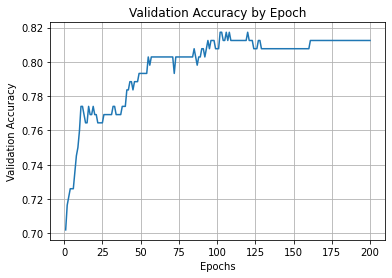

In [41]:
plt.clf()
plt.plot(range(1, len(val_acc_by_epoch_exp1) + 1), val_acc_by_epoch_exp1)
plt.grid()
plt.title('Validation Accuracy by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

Accuracy is fluctuating a lot. Let's smooth it and replot it.

In [42]:
skip_points = 10
smooth_val_acc_exp1 = smooth_curve(val_acc_by_epoch_exp1[skip_points:])

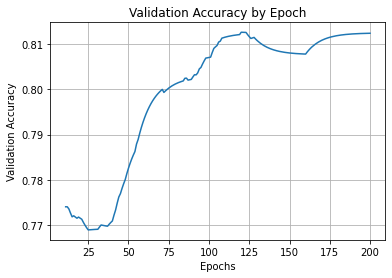

In [43]:
plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp1) + 1), smooth_val_acc_exp1)
plt.grid()
plt.title('Validation Accuracy by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

In [44]:
print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp1)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp1)+skip_points+1))

Max Acc.: 81.27%
Max Acc. Epoch: 120


The validation accuracy peaks at 81% after 120 epochs. We need to improve our model.

## Exp2: Hidden Layers = 1, Hidden Units = 4

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


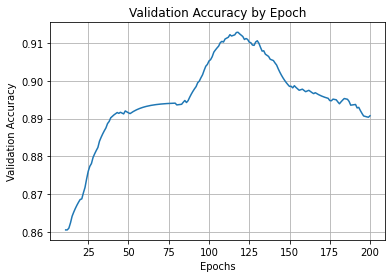

Max Acc.: 91.28%
Max Acc. Epoch: 118


In [45]:
val_acc_by_epoch_exp2 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=200, num_hidden_layers=1, num_hidden_units=4
)
val_acc_by_epoch_exp2 = val_acc_by_epoch_exp2.mean(axis=0)

skip_points = 10
smooth_val_acc_exp2 = smooth_curve(val_acc_by_epoch_exp2[skip_points:])

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp2) + 1), smooth_val_acc_exp2)
plt.grid()
plt.title('Validation Accuracy by Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp2)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp2)+skip_points+1))

## Exp3: Hidden Layers = 1, Hidden Units = 8

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


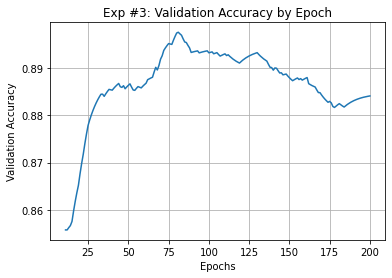

Max Acc.: 89.75%
Max Acc. Epoch: 81


In [46]:
exp_num = 3
val_acc_by_epoch_exp3 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=200, num_hidden_layers=1, num_hidden_units=8
)
val_acc_by_epoch_exp3 = val_acc_by_epoch_exp3.mean(axis=0)

skip_points = 10
smooth_val_acc_exp3 = smooth_curve(val_acc_by_epoch_exp3[skip_points:])

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp3) + 1), smooth_val_acc_exp3)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp3)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp3)+skip_points+1))

## Exp4: Hidden Layers = 1, Hidden Units = 16

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


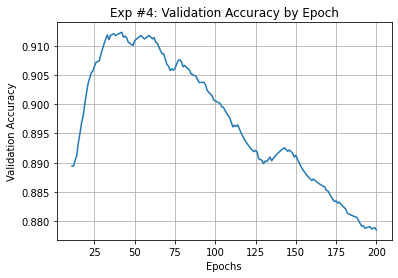

Max Acc.: 91.24%
Max Acc. Epoch: 42


In [47]:
exp_num = 4
val_acc_by_epoch_exp4 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=200, num_hidden_layers=1, num_hidden_units=16
)
val_acc_by_epoch_exp4 = val_acc_by_epoch_exp4.mean(axis=0)

skip_points = 10
smooth_val_acc_exp4 = smooth_curve(val_acc_by_epoch_exp4[skip_points:])

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp4) + 1), smooth_val_acc_exp4)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp4)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp4)+skip_points+1))

## Exp5: Hidden Layers = 1, Hidden Units = 32

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


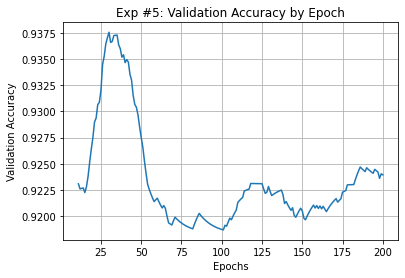

Max Acc.: 93.76%
Max Acc. Epoch: 30


In [48]:
exp_num = 5
val_acc_by_epoch_exp5 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=200, num_hidden_layers=1, num_hidden_units=32
)
val_acc_by_epoch_exp5 = val_acc_by_epoch_exp5.mean(axis=0)

skip_points = 10
smooth_val_acc_exp5 = smooth_curve(val_acc_by_epoch_exp5[skip_points:])

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp5) + 1), smooth_val_acc_exp5)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp5)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp5)+skip_points+1))

## Exp6: Hidden Layers = 1, Hidden Units = 64

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


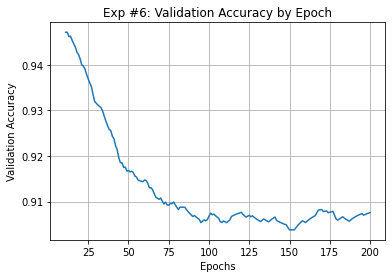

Max Acc.: 94.71%
Max Acc. Epoch: 12


In [49]:
exp_num = 6
val_acc_by_epoch_exp6 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=200, num_hidden_layers=1, num_hidden_units=64
)
val_acc_by_epoch_exp6 = val_acc_by_epoch_exp6.mean(axis=0)

skip_points = 10
smooth_val_acc_exp6 = smooth_curve(val_acc_by_epoch_exp6[skip_points:])

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp6) + 1), smooth_val_acc_exp6)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp6)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp6)+skip_points+1))

## Exp7: Hidden Layers = 1, Hidden Units = 128

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


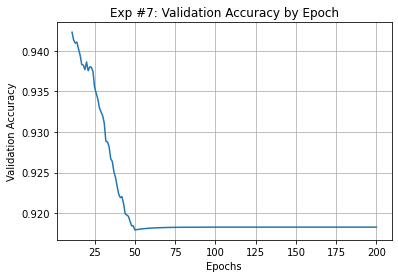

Max Acc.: 94.23%
Max Acc. Epoch: 11


In [50]:
exp_num = 7
val_acc_by_epoch_exp7 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=200, num_hidden_layers=1, num_hidden_units=128
)
val_acc_by_epoch_exp7 = val_acc_by_epoch_exp7.mean(axis=0)

skip_points = 10
smooth_val_acc_exp7 = smooth_curve(val_acc_by_epoch_exp7[skip_points:])

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp7) + 1), smooth_val_acc_exp7)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp7)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp7)+skip_points+1))

## Exp8: Hidden Layers = 1, Hidden Units = 256

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


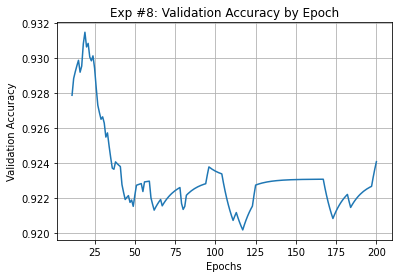

Max Acc.: 93.15%
Max Acc. Epoch: 19


In [53]:
exp_num = 8
val_acc_by_epoch_exp8 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=200, num_hidden_layers=1, num_hidden_units=256
)
val_acc_by_epoch_exp8 = val_acc_by_epoch_exp8.mean(axis=0)

skip_points = 10
smooth_val_acc_exp8 = smooth_curve(val_acc_by_epoch_exp8[skip_points:])

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp8) + 1), smooth_val_acc_exp8)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp8)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp8)+skip_points+1))

## Comparing the Results for 1 Hidden Layer and Varying Number of Hidden Units

The model performs best for 32 and 64 hidden units. Now, let's increase the number of layers to 2 for further experiments.

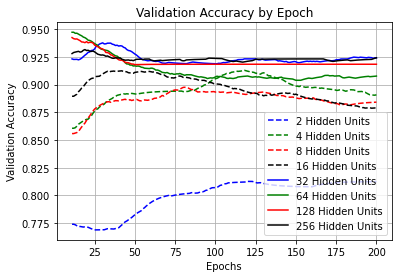

In [54]:
plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp1) + 1), smooth_val_acc_exp1, 'b--')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp2) + 1), smooth_val_acc_exp2, 'g--')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp3) + 1), smooth_val_acc_exp3, 'r--')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp4) + 1), smooth_val_acc_exp4, 'k--')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp5) + 1), smooth_val_acc_exp5, 'b')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp6) + 1), smooth_val_acc_exp6, 'g')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp7) + 1), smooth_val_acc_exp7, 'r')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp8) + 1), smooth_val_acc_exp8, 'k')
plt.grid()
plt.title('Validation Accuracy by Epoch'.format(num=exp_num))
plt.legend(['{units} Hidden Units'.format(units=2**i) for i in range(1, 9)], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

# Model With 2 Hidden Layer

## Exp9: Hidden Layers = 2, Hidden Units = 16

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


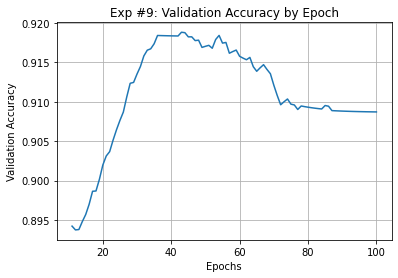

Max Acc.: 91.88%
Max Acc. Epoch: 43


In [55]:
exp_num = 9
val_acc_by_epoch_exp9 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=100, num_hidden_layers=2, num_hidden_units=16
)
val_acc_by_epoch_exp9 = val_acc_by_epoch_exp9.mean(axis=0)

skip_points = 10
smooth_val_acc_exp9 = smooth_curve(val_acc_by_epoch_exp9[skip_points:], factor=0.9)

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp9) + 1), smooth_val_acc_exp9)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp9)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp9)+skip_points+1))

## Exp10: Hidden Layers = 2, Hidden Units = 32

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


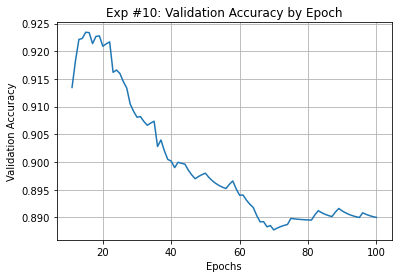

Max Acc.: 92.34%
Max Acc. Epoch: 15


In [56]:
exp_num = 10
val_acc_by_epoch_exp10 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=100, num_hidden_layers=2, num_hidden_units=32
)
val_acc_by_epoch_exp10 = val_acc_by_epoch_exp10.mean(axis=0)

skip_points = 10
smooth_val_acc_exp10 = smooth_curve(val_acc_by_epoch_exp10[skip_points:], factor=0.8)

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp10) + 1), smooth_val_acc_exp10)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp10)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp10)+skip_points+1))

## Exp11: Hidden Layers = 2, Hidden Units = 64

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


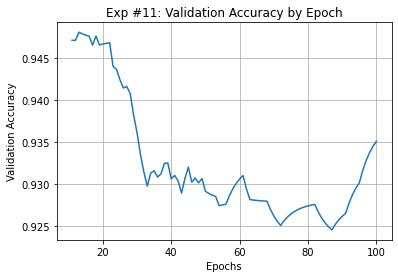

Max Acc.: 94.81%
Max Acc. Epoch: 13


In [57]:
exp_num = 11
val_acc_by_epoch_exp11 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=100, num_hidden_layers=2, num_hidden_units=64
)
val_acc_by_epoch_exp11 = val_acc_by_epoch_exp11.mean(axis=0)

skip_points = 10
smooth_val_acc_exp11 = smooth_curve(val_acc_by_epoch_exp11[skip_points:], factor=0.8)

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp11) + 1), smooth_val_acc_exp11)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp11)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp11)+skip_points+1))

## Exp12: Hidden Layers = 2, Hidden Units = 128

Processing Fold #0
Processing Fold #1
Processing Fold #2
Processing Fold #3
Completed!


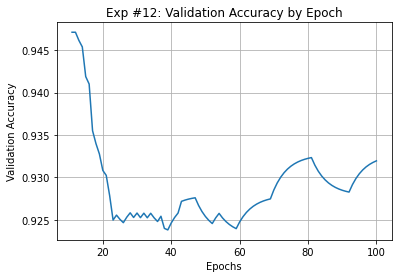

Max Acc.: 94.71%
Max Acc. Epoch: 12


In [58]:
exp_num = 12
val_acc_by_epoch_exp12 = train_and_validate_model_with_k_fold(
    x_train, y_train, k=4, num_epochs=100, num_hidden_layers=2, num_hidden_units=128
)
val_acc_by_epoch_exp12 = val_acc_by_epoch_exp12.mean(axis=0)

skip_points = 10
smooth_val_acc_exp12 = smooth_curve(val_acc_by_epoch_exp12[skip_points:], factor=0.8)

plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp12) + 1), smooth_val_acc_exp12)
plt.grid()
plt.title('Exp #{num}: Validation Accuracy by Epoch'.format(num=exp_num))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

print("Max Acc.: {acc:.2f}%".format(acc=np.max(smooth_val_acc_exp12)*100))
print("Max Acc. Epoch: {epo}".format(epo=np.argmax(smooth_val_acc_exp12)+skip_points+1))

## Comparing the Results for 2 Hidden Layer and Varying Number of Hidden Units

The model performs best for 2 hidden layers and 64 hidden units.

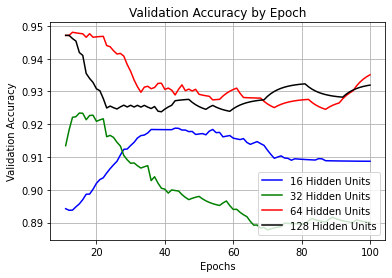

In [59]:
plt.clf()
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp9) + 1), smooth_val_acc_exp9, 'b')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp10) + 1), smooth_val_acc_exp10, 'g')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp11) + 1), smooth_val_acc_exp11, 'r')
plt.plot(range(skip_points + 1, skip_points + len(smooth_val_acc_exp12) + 1), smooth_val_acc_exp12, 'k')
plt.grid()
plt.title('Validation Accuracy by Epoch'.format(num=exp_num))
plt.legend(['{units} Hidden Units'.format(units=2**i) for i in range(4, 8)], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

# Final Model

Our model is givng its best performance with 2 hidden layers and 64 hidden units. So, let's try this configiruration for testing over all the training data and evaluating it on the testing data.

In [60]:
model = build_model(num_hidden_units=64, num_hidden_layers=2)
model.fit(x_train, y_train, epochs=15, batch_size=1)

Epoch 1/15
210/210 [==============================] - 1s 1ms/step - loss: 0.4973 - accuracy: 0.7557
Epoch 2/15
210/210 [==============================] - 0s 1ms/step - loss: 0.2610 - accuracy: 0.9104
Epoch 3/15
210/210 [==============================] - 0s 1ms/step - loss: 0.1733 - accuracy: 0.9422
Epoch 4/15
210/210 [==============================] - 0s 1ms/step - loss: 0.1390 - accuracy: 0.9610
Epoch 5/15
210/210 [==============================] - 0s 1ms/step - loss: 0.0735 - accuracy: 0.9713
Epoch 6/15
210/210 [==============================] - 0s 1ms/step - loss: 0.0517 - accuracy: 0.9840
Epoch 7/15
210/210 [==============================] - 0s 1ms/step - loss: 0.0794 - accuracy: 0.9350
Epoch 8/15
210/210 [==============================] - 0s 1ms/step - loss: 0.0413 - accuracy: 0.9719
Epoch 9/15
210/210 [==============================] - 0s 1ms/step - loss: 0.0270 - accuracy: 0.9910
Epoch 10/15
210/210 [==============================] - 0s 1ms/step - loss: 0.0374 - accuracy: 0.9812

# Final Evaluation

In [63]:
results = model.evaluate(x_test, y_test)
print("Accuracy for Test Dataset: {acc:.2f}%".format(acc=results[1]*100))

5/5 [==============================] - 0s 3ms/step - loss: 0.2370 - accuracy: 0.9571
Accuracy for Test Dataset: 95.71%
